# Finding Flares and Variable Stars: A MAST Case Study

In this tutorial we will learn about MAST's programmatic tools for accessing TESS time series data while exploring a flaring star from the literature.  We will view the flaring star and expore its immediate neighborhood using the MAST API in Python to access and view TESS time series, FFI data, and catalog entries.

Topics to be covered include:
- Using the MAST API to get mission pipeline and TASOC light curves
- Plotting TESS light curves in Python
- Using the MAST API to make an FFI cutout
- Creating a movie of TPF frames in Python
- Using the MAST API to get a list of TESS Input Catalog (TIC) sources
- Over plotting TIC sources on TESS images

See the __[MAST TESS site](http://archive.stsci.edu/tess/)__ for more information and example on how to access and use TESS data.

## Terminology

- **TESS:** The Transiting Exoplanet Survey Satellite
- **TASOC:** The TESS Asteroseismic Science Operations Center
- **Sector:** TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres. Each of these regions is referred to as a "sector", starting with Sector 1.
- **TIC:** The TESS input catalog.
- **FFI:** TESS periodically reads out the entire frame of all four cameras, nominally every 30 minutes, and stores them as full frame images (FFIs). 
- **HDU:** Header Data Unit. A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
- **HDUList:** A list of HDUs that comprise a fits file.
- **BJD:** Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
- **BTJD:** Barycentric TESS Julian Date, the timestamp measured in BJD, but offset by 2457000.0. I.e., BTJD = BJD - 2457000.0
- **WCS:** World Coordinate System, 

## Imports

In this tutorial we will use the MAST module of Astroquery to query and download data.

We will use both the matplotlib and bokeh packages to visualize our data as they have different strengths and weaknesses.

In [46]:
# For querying for data
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u

# For matplotlib plotting
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()

Loading BokehJS ...

## Exploring a stellar flare

### Selecting the flare

We will start with a known flare from the literature, in this case from [G&uuml;nther, M. N., Zhan, Z., Seager, S.,
et al. 2019, arXiv e-prints, arXiv:1901.00443](https://arxiv.org/abs/1901.00443). We picked a particularly long flare to give use the best chance of finding it in the half hour cadence data as well as the 2 minute cadence data.

We've made note of the TIC ID and sector for our flare of interest, as well as its peak time in BJD format:

In [9]:
tic_id = 141914082
sector = 1

tpeak = 2458341.89227 # Julian Day

### Querying MAST

#### Mission light curves

Here we choose the TESS mission (`obs_collection`) and query on our TIC ID and sector.

In [84]:
mission_res = Observations.query_criteria(obs_collection="TESS", 
                                          target_name=tid, 
                                          sequence_number=sector)
mission_res

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str10,int64,str4,str47,str9,float64,float64,float64,float64,float64,str7,str4,float64,float64,str1,str1,float64,str10,str14,str23,str1,str4,int64,str4,str47,str1,str73,str6,bool,float64,str7,str11,str11
timeseries,3,TESS,tess2018206045859-s0001-0000000141914082-0120-s,141914082,94.617684,-72.044877,58324.7928554,58352.6761776,120.0,Optical,TESS,600.0,1000.0,--,--,58458.58333,Photometer,"Ricker, George",G011175_G011180_G011176,--,TESS,1,SPOC,CIRCLE ICRS 94.61768400 -72.04487700 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000141914082-0120-s_lc.fits,PUBLIC,False,--,science,17000010608,17002494510


#### TASOC light curves

MAST also hosts a variety of community contributed High Level Science Products (HLSPs), all of which are given the mission "HLSP". In this case we will specifically search for HLSPs that use the "TESS" filter, which will return the light curves provided by the TASOC (note the `provenance_name` of "TASOC").

In [10]:
tasoc_res = Observations.query_criteria(target_name=tid, 
                                        obs_collection="HLSP", 
                                        filters="TESS",
                                        sequence_number=sector)
tasoc_res

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str10,int64,str4,str56,str9,float64,float64,float64,float64,float64,str7,str4,float64,float64,str1,str1,float64,str10,str15,str15,str1,str4,int64,str5,str47,str1,str107,str6,bool,float64,str7,str11,str11
timeseries,4,HLSP,hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc,141914082,94.6176839993,-72.0448770008,58324.7932596,58352.676349,120.0,Optical,TESS,600.0,1000.0,--,--,58645.4456,Photometer,Rasmus Handberg,G011155_G011160,--,TESS,1,TASOC,CIRCLE ICRS 94.61768400 -72.04487700 0.00583333,--,mast:HLSP/tasoc/s0001/tpf/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc.fits,PUBLIC,False,--,science,18000000110,18000740747
timeseries,4,HLSP,hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc,141914082,94.6176839993,-72.0448770008,58324.8130548,58352.666915,1800.0,Optical,TESS,600.0,1000.0,--,--,58645.51369,Photometer,Rasmus Handberg,G011155_G011160,--,TESS,1,TASOC,CIRCLE ICRS 94.61768400 -72.04487700 0.00583333,--,mast:HLSP/tasoc/s0001/ffi/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc.fits,PUBLIC,False,--,science,18000182858,18000885251


In this case there are two light curves, to understand the difference between the two light curves we look to the `t_exptime` column:

In [88]:
print(tasoc_res["t_exptime"])

t_exptime
---------
    120.0
   1800.0


These exposure times correspond to 2 minutes (short cadence) and 30 minutes (long cadence). We will explore both light curves.

### Downloading the data products

From here on we will only deal with the TASOC light curves, although we could do the same with the mission pipeline light curves as well.

#### Querying for the list of associated data products

Each observastion may have one or more associated data product. In the case of the TASOC light curves, there is simply a single light curve file for each observation. 

In [86]:
tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

dataproduct_type,description,dataURI,size
str10,str4,str107,int64
timeseries,FITS,mast:HLSP/tasoc/s0001/tpf/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc.fits,1877760
timeseries,FITS,mast:HLSP/tasoc/s0001/ffi/0000/0001/4191/4082/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc.fits,161280


#### Downloading files

We can choose do download some or all of the associated data files, in this case since we just have the two light curves, we will download all of the products.

In [87]:
tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc.fits with expected size 1877760. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc.fits with expected size 161280. [astroquery.query]


Local Path,Status,Message,URL
str138,str8,object,object
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00141914082-s01-c0120_tess_v04_lc.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00141914082-s01-c1800_tess_v04_lc.fits,COMPLETE,None,None


### Plotting the light curves

We will use bokeh for plotting rather than matplotlib so we can have interactivity, and will plot both the 2 minute and 30 mintue cadence data. 

We can tell which is which by examining the filenames and noting that one contains `c0120` (2 min) and the other `c1800` (30 min).

In [91]:
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

In [92]:
hdu = fits.open(tasoc_manifest["Local Path"][1])
long_cad_lc = Table(hdu[1].data)
hdu.close()

In [93]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tid})")

# Short cadence
bfig.circle(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], fill_color="black",size=2, line_color=None)
bfig.line(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], line_color='black')

# Long cadence
bfig.circle(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], fill_color="#553be7",size=6, line_color=None)
bfig.line(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], line_color='#553be7')

# Marking the flare (tpeak is in BJD, while the time column in the light curve is BTJD, so we must convert)
vline = Span(location=(tpeak - 2457000), dimension='height', line_color='#8c0051', line_width=1)
bfig.renderers.extend([vline])

plotting.show(bfig)

### Making a video

Looking at the above plot we can see the flare event in both the long and short cadence light curves. Since we can see it at even a half hour cadence, we should be able to make a movie of the area around the flaring star and see it.

We will use TESScut, the MAST cutout tool for full-frame images to cutout the area around accross the entire sector, and then make a movie that shows how it changes over time.

We will use the `astroquery.mast` __[Tesscut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#tesscut)__ class to make this cutout.  
We will use two functions:
- Find the sky coordinate of our flare star: `Observations._resolve_object`\*
- Query for cutouts and get the result as a list of HDUList objects: `Tesscut.get_cutouts` \*\*

\* `Observations._resolve_object` is a private (not documented) function which is being removed in favore of the public function `Observations.resolve_object` in the next Astroquery release.

\*\* We must start by finding the sky coordinate of our star, however starting with the next Astroquery release, `Tescut` functions will be able to take an object name such as a TIC ID as well.

In [ ]:
coord = Observations._resolve_object(f"TIC {tid}")

**Requesting a cutout target pixel file. **

This query will return a list of `HDUList` objects, each of which is the cutout target pixel file for a single sector. In this case, because we did a sector query and know that our target only appears in one sector, we know that the resulting list will only have one element and can pull it out directly.

In [56]:
cutout_hdu = Tesscut.get_cutouts(coordinates=coord, size=40, sector=1)[0]

In [57]:
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (40, 40)   int32   


In [58]:
cutout_table = Table(cutout_hdu[1].data)
cutout_table.columns

#### Exploring the cutout time series

We want to explore what is happening with in our cutout area over the time that the flare occurs, so we will make an animated plot of the cutout frames.

We can't make a movie of the whole sector (it would take too long), so we will choose only the time range around the flare.

In [60]:
def find_index(btjd):
    """
    Given a time as a Barycentric TESS Julian Date (BTJD) timestamp, return the closest index in a table
    that is assumed to have a TIME column that is also in BTJD"""
    
    return (np.abs(cutout_table['TIME'] - btjd)).argmin()

In [61]:
start = find_index(1341.5)
end = find_index(1342.5)

print(f"Frames {start}-{end} ({end-start} frames)")

Frames 721-769 (48 frames)


#### Looking at the animated cutout

In [95]:
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani

In [96]:
make_animation(cutout_table['FLUX'], start, end, vmax=700, delay=150)

We can see three things in this plot:
- The flare that occures in epoch 740-743
- An abberition that appears in epoch 754
- A variable star pulsing in the lower right corner

## Exploring the variable star

Now we will look more closely at the variable star we can see in the animation. 

### Querying the TESS Input Catalog

To start with we will overlay the nearby TIC sources onto the image so we can identify the star in question. To do this we will use the `astroquery.mast` Catalog clas to search the TIC.

In [97]:
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {tid}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(sources)

    ID          ra           dec       ... raddflag wdflag    dstArcSec    
--------- ------------- -------------- ... -------- ------ ----------------
141914082 94.6175354048  -72.044846222 ...        1      0 8.9129249851e-06
141914038 94.7353652417 -72.0837957852 ...        0      0    191.637413441
141914103 94.7749592275 -72.0227841314 ...        0      0    192.006562554
141914130 94.5074642175 -71.9989305821 ...        1      0    205.624853325
141914317 94.9032150267 -72.0334742503 ...        1      0     319.77006822
141913994 94.5588022853 -72.1321979465 ...        1      0    321.119226791
166975135 94.6067354129 -71.9255734581 ...        0      0    429.550265414
141869504 94.2183733432 -72.0232095514 ...        0      0    450.031745584
141913929   94.70998361 -72.1924762406 ...        0      0    541.203095946


### Overlaying the sources on a single cutout image

We will get the WCS infomation assocaited with our cutout so that we can make a WCS-aware plot, and identify a single cutout image to show. Then we display the image and sources together, and label the sources with their row number in the catalog table.

In [62]:
cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start]

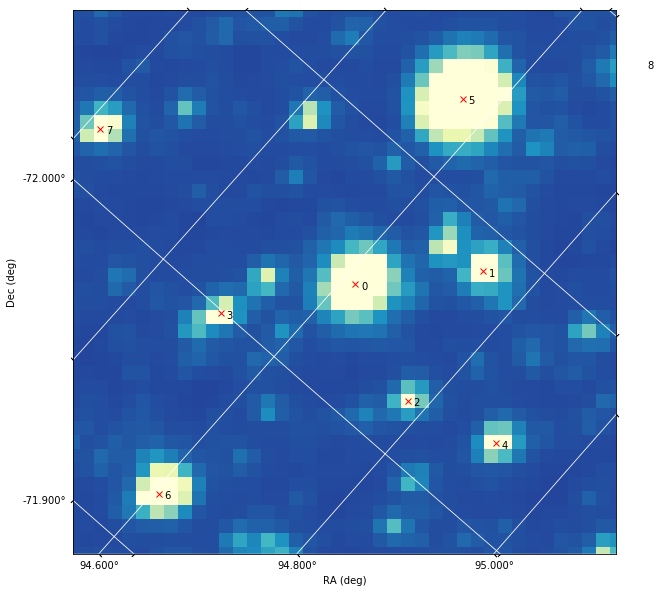

In [98]:
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

The variable star is row 4 in the catalog sources table.

In [80]:
sources["ID","ra","dec"][4]

ID,ra,dec
str11,float64,float64
141914317,94.9032150267,-72.0334742503


### Getting the variable star light curve

Again, we will look specifically for the TASOC light curve(s) associated with this star, rather than the mission pipeline ones. Below we go through the same process to serch for the observation, then find the associated data products, and download them.

In [67]:
variable_tic_id = sources["ID"][4]

variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {tid}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

Number of tasoc light curves for 141914317: 1

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00141914317-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00141914317-s01-c1800_tess_v04_lc.fits with expected size 161280. [astroquery.query]


Note that this time there is only one TASOC light curve, and it is at the 30 minute cadence.  This was not a star that TESS observed at the short cadence.

In [103]:
hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

### Plotting the variable star light curve

We wil again plot the light curve using bokeh, for the interactive tools.

In [104]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tid})")

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

plotting.show(bfig)

That look variable all right!

### Finding the period

We'll run a quick Lomb Scargle priodogram on this light curve to see if we can quantify the periodic behavior. To do this we will use the `astropy.timeseries` class LombScargle (LINK THIS).

In [105]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["FLUX_RAW"])
frequency, power = lomb.autopower()

#### Plotting the periodogram

In [106]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tid})")

bfig.line(frequency, power, line_color='black')

plotting.show(bfig)

#### Phasing on the highest power period

We will pick out the highest powered period in the abover periodogram and phase the stellar light curve on that period.

In [107]:
period = 1/frequency[np.argmax(power)].value
period

0.009942852448487789

In [118]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tid})")

bfig.circle(variable_lc["TIME"]%period,variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)

t_fit = np.linspace(0,period,100)
bfig.line(t_fit, lomb.model(t_fit, 1/period), color='#1b9f00', line_width=2)

plotting.show(bfig)